#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션

단계별로 나눠서 모델링을 수행하고자 합니다.  

* 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
* 단계2 : 세부 동작에 대한 분류모델 생성
    * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
    * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 모든 모델링은 [다양한 알고리즘 + 성능 튜닝]을 수행해야 합니다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifier

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용

 <br/>  

* 세부 요구사항
    - data01_train.csv 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - data01_test.csv 를 불러와 'new_data' 이름으로 저장합니다.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 전체 데이터 'data01_train.csv' 를 불러와 'data' 이름으로 저장
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/train.csv')
new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/test.csv')

# data에서 변수 subject는 삭제
data.drop(columns = ['Unnamed: 0','timestamp'], inplace=True)
new_data.drop(columns = ['Unnamed: 0','timestamp'], inplace=True)

#### 2) 기본 정보 조회

In [ ]:
display(data.head())
display(new_data.head())

,A_x,A_y,A_z,B_x,B_y,B_z,label
0,-0.259130,-0.834869,-0.485499,0.196409,NaN,0.384934,8
1,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,2
2,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,8
3,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,11
4,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,6


,A_x,A_y,A_z,B_x,B_y,B_z
0,-1.000957,-0.170691,0.124889,-0.979561,0.003150,-0.264673
1,-0.874830,0.132696,-0.501727,-1.274911,0.045122,0.121270
2,-1.219112,0.074678,0.435331,-0.860820,0.222740,0.008689
3,-0.907752,-0.171816,0.211507,-0.972017,0.337799,1.013534
4,-1.031261,0.000340,-0.091693,-0.217434,-0.323466,0.931614


In [ ]:
print(data.shape)
print(new_data.shape)

(100000, 7)
(13234, 6)


In [ ]:
data.dropna(inplace = True)
new_data.dropna(inplace = True)

In [ ]:
print(data.info())
print(new_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53219 entries, 1 to 99999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A_x     53219 non-null  float64
 1   A_y     53219 non-null  float64
 2   A_z     53219 non-null  float64
 3   B_x     53219 non-null  float64
 4   B_y     53219 non-null  float64
 5   B_z     53219 non-null  float64
 6   label   53219 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 3.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13234 entries, 0 to 13233
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A_x     13234 non-null  float64
 1   A_y     13234 non-null  float64
 2   A_z     13234 non-null  float64
 3   B_x     13234 non-null  float64
 4   B_y     13234 non-null  float64
 5   B_z     13234 non-null  float64
dtypes: float64(6)
memory usage: 620.5 KB
None


In [ ]:
print(data.describe())
print(new_data.describe())

                A_x           A_y           A_z           B_x           B_y  \
count  53219.000000  53219.000000  53219.000000  53219.000000  53219.000000   
mean      -0.877294     -0.108733     -0.013489     -0.779756      0.115047   
std        0.463339      0.347211      0.361346      0.813368      0.592512   
min       -5.112929     -1.949310     -1.284750     -7.483251     -5.381570   
25%       -1.016930     -0.179784     -0.281388     -1.049334     -0.192097   
50%       -0.958883     -0.047223     -0.063627     -0.918018      0.022717   
75%       -0.766159      0.060663      0.221118     -0.158293      0.317289   
max        1.849398      2.413866      2.457464      5.372528      7.182237   

                B_z         label  
count  53219.000000  53219.000000  
mean       0.165634      5.929762  
std        0.786266      3.334749  
min       -7.208220      1.000000  
25%       -0.245943      3.000000  
50%        0.111824      6.000000  
75%        0.526061      9.000000  


## 2.그냥 돌려보기

<< 기초통계량 >>


,count,mean,std,min,25%,50%,75%,max
label,53219.0,5.929762,3.334749,1.0,3.0,6.0,9.0,11.0


<< 그래프 >>
<< 범주별 빈도수 >>
2     6453
1     6188
8     6056
7     5670
10    5068
9     4891
11    4838
3     4428
4     3853
5     2913
6     2861
Name: label, dtype: int64
<< 범주별 비율 >>
2     0.121254
1     0.116274
8     0.113794
7     0.106541
10    0.095229
9     0.091903
11    0.090907
3     0.083203
4     0.072399
5     0.054736
6     0.053759
Name: label, dtype: float64


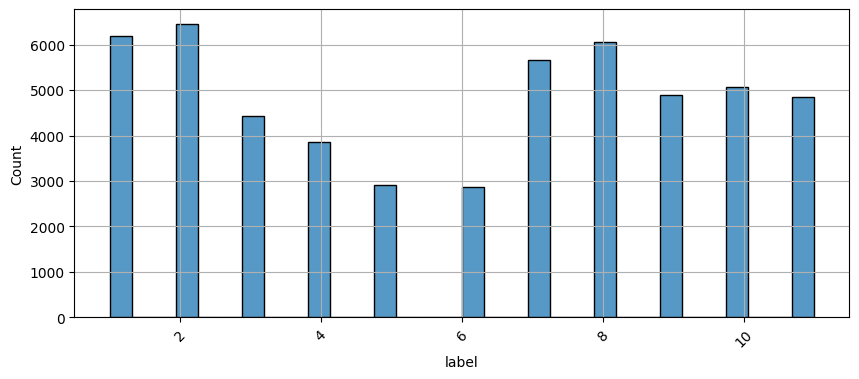

In [ ]:
def eda_1_num(data, target):

    # 기초통계량
    print('<< 기초통계량 >>')
    display(data[[target]].describe().T)
    print('=' * 100)

    # 시각화
    print('<< 그래프 >>')
    plt.figure(figsize=(10, 4))
    sns.histplot(data[target])
    plt.grid()
    plt.xticks(rotation=45)

    category_counts = data[target].value_counts()
    category_proportions = data[target].value_counts(normalize=True)

    print('<< 범주별 빈도수 >>')
    print(category_counts)
    print('=' * 100)

    print('<< 범주별 비율 >>')
    print(category_proportions)
    print('=' * 100)

target = 'label'
eda_1_num(data, target)

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE 객체 생성
smote = SMOTE(random_state=42)
y_train = data['label']
X_train = data.drop(columns = 'label')
# X_train, y_train은 훈련 데이터의 특징과 레이블을 나타냅니다.
# 이 두 변수를 사용하여 SMOTE를 적용합니다.
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)  # X_train.columns는 특징 열의 이름들을 나타냅니다
y_resampled_df = pd.Series(y_resampled, name='label')  # 'target'은 새로운 레이블 열의 이름입니다

# X_resampled_df와 y_resampled_df를 합쳐서 resampled_df를 생성
resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)
resampled_df

,A_x,A_y,A_z,B_x,B_y,B_z,label
0,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,2
1,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,8
2,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,11
3,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,6
4,-0.654583,0.068285,-0.029109,-0.176341,-0.256252,-0.510816,2
...,...,...,...,...,...,...,...
70978,-0.937101,-0.115067,0.341359,-0.805431,-0.263936,0.182348,11
70979,-0.997864,-0.074420,0.273372,-1.073208,0.212859,0.068700,11
70980,-0.926530,-0.058349,0.468366,-1.258490,-0.058865,0.092309,11
70981,-0.596472,-0.015233,0.280113,-1.097080,0.130267,0.125839,11


<< 기초통계량 >>


,count,mean,std,min,25%,50%,75%,max
label,70983.0,6.0,3.1623,1.0,3.0,6.0,9.0,11.0


<< 그래프 >>
<< 범주별 빈도수 >>
2     6453
8     6453
11    6453
6     6453
4     6453
5     6453
10    6453
1     6453
3     6453
7     6453
9     6453
Name: label, dtype: int64
<< 범주별 비율 >>
2     0.090909
8     0.090909
11    0.090909
6     0.090909
4     0.090909
5     0.090909
10    0.090909
1     0.090909
3     0.090909
7     0.090909
9     0.090909
Name: label, dtype: float64


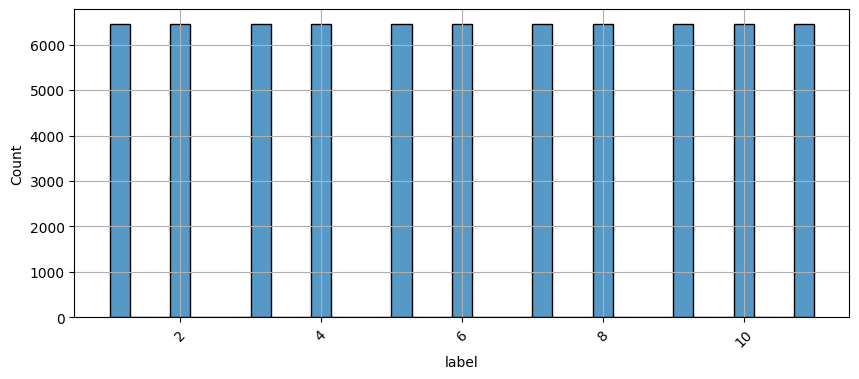

In [ ]:
def eda_1_num(data, target):

    # 기초통계량
    print('<< 기초통계량 >>')
    display(data[[target]].describe().T)
    print('=' * 100)

    # 시각화
    print('<< 그래프 >>')
    plt.figure(figsize=(10, 4))
    sns.histplot(data[target])
    plt.grid()
    plt.xticks(rotation=45)

    category_counts = data[target].value_counts()
    category_proportions = data[target].value_counts(normalize=True)

    print('<< 범주별 빈도수 >>')
    print(category_counts)
    print('=' * 100)

    print('<< 범주별 비율 >>')
    print(category_proportions)
    print('=' * 100)

target = 'label'
eda_1_num(resampled_df, target)

In [ ]:
resampled_df

,A_x,A_y,A_z,B_x,B_y,B_z,label
0,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,2
1,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,8
2,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,11
3,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,6
4,-0.654583,0.068285,-0.029109,-0.176341,-0.256252,-0.510816,2
...,...,...,...,...,...,...,...
70978,-0.937101,-0.115067,0.341359,-0.805431,-0.263936,0.182348,11
70979,-0.997864,-0.074420,0.273372,-1.073208,0.212859,0.068700,11
70980,-0.926530,-0.058349,0.468366,-1.258490,-0.058865,0.092309,11
70981,-0.596472,-0.015233,0.280113,-1.097080,0.130267,0.125839,11


In [ ]:
new_data

,A_x,A_y,A_z,B_x,B_y,B_z
0,-1.000957,-0.170691,0.124889,-0.979561,0.003150,-0.264673
1,-0.874830,0.132696,-0.501727,-1.274911,0.045122,0.121270
2,-1.219112,0.074678,0.435331,-0.860820,0.222740,0.008689
3,-0.907752,-0.171816,0.211507,-0.972017,0.337799,1.013534
4,-1.031261,0.000340,-0.091693,-0.217434,-0.323466,0.931614
...,...,...,...,...,...,...
13229,-1.379061,0.070504,-0.528339,-1.154145,0.097546,-0.537505
13230,-1.039895,-0.122421,0.065954,-1.152930,0.294010,1.080373
13231,-1.176883,-0.218801,-0.581625,-0.809665,0.126385,0.314077
13232,-0.912287,-0.148846,-0.141693,-1.382983,0.102818,0.933066


In [ ]:
# x, y로 나누기
y = resampled_df['label']
x = resampled_df.drop(columns = 'label')

# train과 validation 분할 수행
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x, y, stratify = y, random_state=42, test_size=0.2)

In [ ]:
for _ in range(5):
    from sklearn.ensemble import RandomForestClassifier
    model_RF = RandomForestClassifier()
    model_RF.fit(X_train, y_train)

    # 성능 평가
    from sklearn.metrics import accuracy_score
    y_pred = model_RF.predict(X_val)
    print(accuracy_score(y_val, y_pred))


0.9204761569345636
0.9208987814326971
0.9200535324364302
0.9204761569345636
0.9195604705219412


In [ ]:
# 스케일링 (선택사항)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier()
model_RF.fit(x, y)

# 성능 평가
from sklearn.metrics import accuracy_score
y_pred = model_RF.predict(new_data)
# print(accuracy_score(y_val, y_pred))

# 예측 결과를 DataFrame으로 만들기
result_df = pd.DataFrame({'label': y_pred})

# CSV 파일로 저장
result_df.to_csv('prediction_results1.csv', index_label='ID')

pd.read_csv('prediction_results1.csv')


,ID,label
0,0,6
1,1,4
2,2,11
3,3,9
4,4,7
...,...,...
13229,13229,4
13230,13230,9
13231,13231,4
13232,13232,1


In [ ]:
for n in range(3):
    models = [
            ('ada', AdaBoostClassifier()),
            ('bc', BaggingClassifier()),
            ('etc',ExtraTreesClassifier()),
            ('gbc', GradientBoostingClassifier()),
            ('rfc', RandomForestClassifier()),
            ('knn', KNeighborsClassifier()),
            ('svc', SVC(probability=True)),
            ('xgb', XGBClassifier()),
            # ('lgbm', LGBMClassifier()),
            ('dtc', DecisionTreeClassifier()),
            ('lr', LogisticRegressionCV(max_iter=1000)),
            # ('ridge', RidgeClassifier()),
        ]

    from sklearn.ensemble import VotingClassifier

    # 투표 모델 생성
    voting_soft = VotingClassifier(models, voting='soft')
    voting_hard = VotingClassifier(models, voting='hard')

    # 투표 모델 학습
    voting_soft.fit(X_train, y_train)
    voting_hard.fit(X_train, y_train)

    # 최종 예측
    final_predictions = voting_soft.predict(X_val)
    final_predictions2 = voting_hard.predict(X_val)

    from sklearn.metrics import accuracy_score, f1_score

    final_accuracy = accuracy_score(y_val, final_predictions)
    final_macro_f1 = f1_score(y_val, final_predictions, average='macro')

    final_accuracy2 = accuracy_score(y_val, final_predictions2)
    final_macro_f12 = f1_score(y_val, final_predictions2, average='macro')


    print(f"n={n}: Final voting_soft Accuracy={final_accuracy:.4f}, Final voting_soft Macro F1 Score={final_macro_f1:.4f}")
    print(f"n={n}: Final voting_soft Accuracy={final_accuracy2:.4f}, Final voting_soft Macro F1 Score={final_macro_f12:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

n=0: Final voting_soft Accuracy=0.9155, Final voting_soft Macro F1 Score=0.9155
n=0: Final voting_soft Accuracy=0.9133, Final voting_soft Macro F1 Score=0.9133


KeyboardInterrupt: ignored

In [ ]:
models = [
        # ('ada', AdaBoostClassifier()),
        ('rfc', RandomForestClassifier()),
        ('knn', KNeighborsClassifier()),
        ('svc', SVC(probability=True)),
        ('xgb', XGBClassifier()),
        ('dtc', DecisionTreeClassifier()),
        ('lr', LogisticRegressionCV(max_iter=1000)),
    ]

from sklearn.ensemble import VotingClassifier

# 투표 모델 생성
voting_soft = VotingClassifier(models, voting='soft')
# voting_hard = VotingClassifier(models, voting='hard')

# 투표 모델 학습
voting_soft.fit(X_train, y_train)
# voting_hard.fit(X_train, y_train)

# 최종 예측
final_predictions = voting_soft.predict(X_val)
# final_predictions2 = voting_hard.predict(X_val)

from sklearn.metrics import accuracy_score, f1_score

final_accuracy = accuracy_score(y_val, final_predictions)
final_macro_f1 = f1_score(y_val, final_predictions, average='macro')

# final_accuracy2 = accuracy_score(y_val, final_predictions2)
# final_macro_f12 = f1_score(y_val, final_predictions2, average='macro')

print(f"n={n}: Final voting_soft Accuracy={final_accuracy:.4f}, Final voting_soft Macro F1 Score={final_macro_f1:.4f}")
# print(f"n={n}: Final voting_hard Accuracy={final_accuracy2:.4f}, Final voting_hard Macro F1 Score={final_macro_f12:.4f}")


n=1: Final voting_soft Accuracy=0.9141, Final voting_soft Macro F1 Score=0.9140


In [ ]:
models = [
            ('ada', AdaBoostClassifier()),
            ('bc', BaggingClassifier()),
            # ('etc',ExtraTreesClassifier()),
            ('gbc', GradientBoostingClassifier()),
            ('rfc', RandomForestClassifier()),
            ('knn', KNeighborsClassifier()),
            # ('svc', SVC(probability=True)),
            ('xgb', XGBClassifier()),
            ('dtc', DecisionTreeClassifier()),
            ('lr', LogisticRegression(max_iter=1000)),
            # ('ridge', RidgeClassifier()),
]

final_estimator = RandomForestClassifier()

# StackingClassifier로 생성한 모델
stacking_clf = StackingClassifier(estimators=models, final_estimator=final_estimator)

# StackingClassifier 모델 학습
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('ada', AdaBoostClassifier()),
                               ('bc', BaggingClassifier()),
                               ('etc', ExtraTreesClassifier()),
                               ('gbc', GradientBoostingClassifier()),
                               ('rfc', RandomForestClassifier()),
                               ('knn', KNeighborsClassifier()),
                               ('svc', SVC(probability=True)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_byn...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('dtc', DecisionTreeClassifier()),
                               ('lr', LogisticRegression(max_iter=1000))],
                   final_estimator=RandomForestClassifier())

In [ ]:
# 최종 예측
final_predictions = stacking_clf.predict(X_val)

from sklearn.metrics import accuracy_score, f1_score

final_accuracy = accuracy_score(y_val, final_predictions)
final_macro_f1 = f1_score(y_val, final_predictions, average='macro')

print(f"Final voting_soft Accuracy={final_accuracy:.4f}, Final voting_soft Macro F1 Score={final_macro_f1:.4f}")

Final voting_soft Accuracy=0.9301, Final voting_soft Macro F1 Score=0.9302


In [ ]:
y_pred = stacking_clf.predict(new_data)

# 예측 결과를 DataFrame으로 만들기
result_df = pd.DataFrame({'label': y_pred})

# CSV 파일로 저장
result_df.to_csv('prediction_results777.csv', index_label='ID')

pd.read_csv('prediction_results777.csv')

,ID,label
0,0,6
1,1,4
2,2,11
3,3,9
4,4,7
...,...,...
13229,13229,4
13230,13230,9
13231,13231,4
13232,13232,1
